In [ ]:
# %pip install pandas
# %pip install matplotlib
# %pip insall numpy
# %pip install seaborn
# %pip install requests
%pip install statsmodels

In [1]:
# importing data
# IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

IMPORT AND CLEAN DATASET

In [2]:
# import the dataset
import requests

# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
dataset_ids = ["daily-shelter-overnight-service-occupancy-capacity", "central-intake-calls"]

for d_id in dataset_ids:
    url = base_url + "/api/3/action/package_show"
    params = { "id": d_id }
    package = requests.get(url, params = params).json()
    
    for idx, resource in enumerate(package["result"]["resources"]):
        if resource["datastore_active"]:
           # Get all records in CSV format:
           url = base_url + "/datastore/dump/" + resource["id"]
           resource_dump_data = requests.get(url).text
           # Save CSV files
           filename = resource['name'].lower().replace(' ', '_')
           f = open(filename + '.csv', "w")
           f.write(resource_dump_data)
           f.close()

In [ ]:
# see datasets
shelter_use2023 = pd.read_csv("daily_shelter_overnight_occupancy.csv")
shelter_use2022 = pd.read_csv("daily-shelter-overnight-service-occupancy-capacity-2022.csv")
shelter_use2021 = pd.read_csv("daily-shelter-overnight-service-occupancy-capacity-2021.csv")

print(shelter_use2021.head(10))

In [4]:
# match date formats to YYYY-MM-DD
shelter_use2021["OCCUPANCY_DATE"] = pd.to_datetime(shelter_use2021["OCCUPANCY_DATE"], format='%y-%m-%d')
shelter_use2021["OCCUPANCY_DATE"] = shelter_use2021["OCCUPANCY_DATE"].dt.strftime('%Y-%m-%d')

shelter_use2022["OCCUPANCY_DATE"] = pd.to_datetime(shelter_use2022["OCCUPANCY_DATE"], format='%y-%m-%d')
shelter_use2022["OCCUPANCY_DATE"] = shelter_use2022["OCCUPANCY_DATE"].dt.strftime('%Y-%m-%d')

In [23]:
# create a combined object
shelter_use_combined = pd.concat([shelter_use2023, shelter_use2022, shelter_use2021], ignore_index=True)

# drop unnecesary columns + data points
toronto = shelter_use_combined[shelter_use_combined['LOCATION_CITY'] == 'Toronto']
toronto['FSA_code'] = toronto["LOCATION_POSTAL_CODE"].str[:3]

# drop unnecessary columns
toronto_shelter_usage_all = toronto[["OCCUPANCY_DATE", "FSA_code", "SERVICE_USER_COUNT"]]

# fill in the NA values
toronto_shelter_usage_all.fillna(0, inplace=True)
print(toronto_shelter_usage_all.head(10))

# convert index to datetime
toronto_shelter_usage_all.index = pd.to_datetime(toronto_shelter_usage_all["OCCUPANCY_DATE"], format='%Y-%m-%d')
toronto_shelter_usage_all.sort_index(inplace=True)

toronto_shelter_usage_all = toronto_shelter_usage_all.groupby(['FSA_code', toronto_shelter_usage_all.index]).agg({'SERVICE_USER_COUNT': 'sum'}).reset_index()

# convert index to datetime
toronto_shelter_usage_all.index = pd.to_datetime(toronto_shelter_usage_all["OCCUPANCY_DATE"], format='%Y-%m-%d')
toronto_shelter_usage_all.sort_index(inplace=True)

# Display the first few rows of the aggregated data
toronto_shelter_usage_all.head()


   OCCUPANCY_DATE FSA_code  SERVICE_USER_COUNT
0      2023-01-01      M9W                 614
1      2023-01-01      M9W                 111
2      2023-01-01      M5S                   8
6      2023-01-01      M6R                  39
7      2023-01-01      M6H                  39
8      2023-01-01      M6G                  18
9      2023-01-01      M6G                  66
10     2023-01-01      M1P                 220
15     2023-01-01      M3M                  18
16     2023-01-01      M4P                 146


,FSA_code,OCCUPANCY_DATE,SERVICE_USER_COUNT
OCCUPANCY_DATE,,,
2021-01-01,M1E,2021-01-01,156
2021-01-01,M1P,2021-01-01,156
2021-01-01,M5E,2021-01-01,79
2021-01-01,M5H,2021-01-01,50
2021-01-01,M5J,2021-01-01,194


In [24]:
#subset training group
# toronto_shelter_usage_all.index = pd.to_datetime(toronto_shelter_usage_all.index, format='%Y-%m-%d')
# toronto_shelter_usage_all.sort_index(inplace=True)
toronto_shelter_usage_train = toronto_shelter_usage_all[toronto_shelter_usage_all.index < pd.to_datetime("2023-01-01")]

# group by FSA code and date
userc_by_fsa = toronto_shelter_usage_train.groupby(['FSA_code', toronto_shelter_usage_train.index]).agg({'SERVICE_USER_COUNT': 'sum'}).reset_index()
userc_by_fsa.index = pd.to_datetime(userc_by_fsa["OCCUPANCY_DATE"], format='%Y-%m-%d')
userc_by_fsa.sort_index(inplace=True)
userc_by_fsa.head()

,FSA_code,OCCUPANCY_DATE,SERVICE_USER_COUNT
OCCUPANCY_DATE,,,
2021-01-01,M1E,2021-01-01,156
2021-01-01,M2M,2021-01-01,25
2021-01-01,M5B,2021-01-01,406
2021-01-01,M5A,2021-01-01,881
2021-01-01,M3B,2021-01-01,13


In [26]:
print(by_fsa.index)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='OCCUPANCY_DATE', length=730, freq=None)


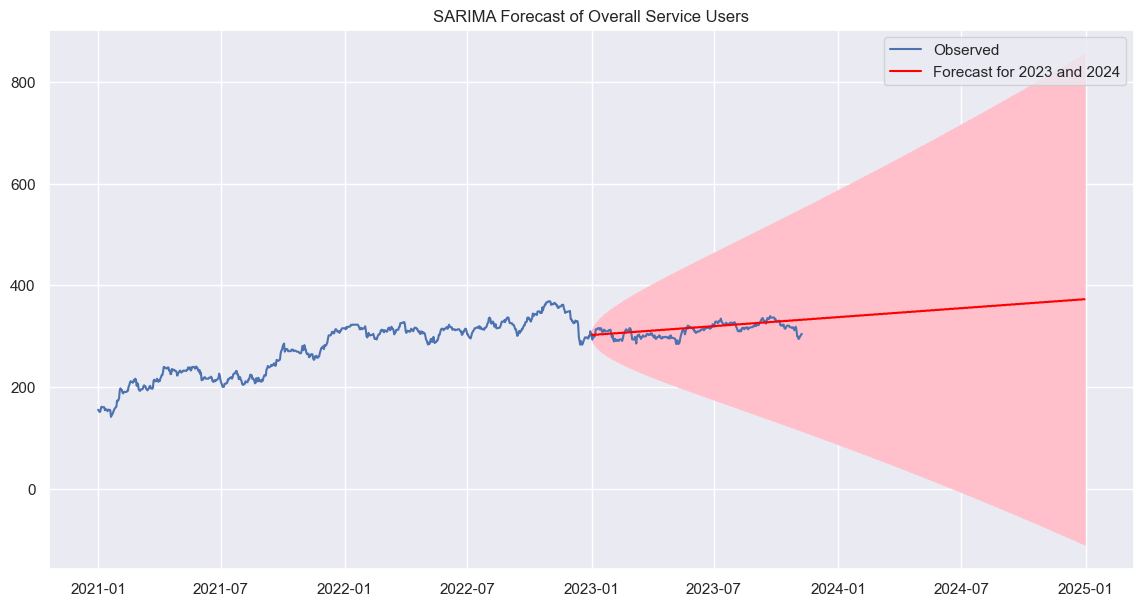

In [39]:
    # for 1 area: 
FSA = 'M1E'

by_fsa = userc_by_fsa[userc_by_fsa["FSA_code"] == FSA] 
# by_fsa = by_fsa["OCCUPANCY_DATE, SERVICE_USER_COUNT"]
# Define a SARIMA model for the aggregated time series data
# The order parameter specifies the AR, differencing, and MA terms, respectively.
# The seasonal_order parameter adds seasonal terms with a weekly periodicity (specified as 7).
model_overall_users = SARIMAX(by_fsa["SERVICE_USER_COUNT"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality assumed

# Fit the SARIMA model to the data.
# The disp=False argument suppresses convergence output for cleaner presentation.
sarima_overall_users_result = model_overall_users.fit(disp=False)

# Forecast the service users for the next 730 days (covering 2023 and 2024).
forecast_overall_users = sarima_overall_users_result.get_forecast(steps=730)

# Extract the mean forecast values from the forecast results.
mean_forecast_overall_users = forecast_overall_users.predicted_mean

# Extract the confidence intervals for the forecast. 
# This provides an upper and lower bound for the forecast, indicating the uncertainty.
confidence_intervals_overall_users = forecast_overall_users.conf_int()

# Set up the figure and axis for plotting with a specified size.
plt.figure(figsize=(14, 7))

# Plot the observed data in blue.
all_by_fsa = toronto_shelter_usage_all["SERVICE_USER_COUNT"][toronto_shelter_usage_all["FSA_code"] == FSA]
# print(all_by_fsa.index)
# print(all_by_fsa.head())
plt.plot(all_by_fsa.index, all_by_fsa, label='Observed')
# print(toronto_shelter_usage_all.index)
# print(toronto_shelter_usage_all["SERVICE_USER_COUNT"])

# Plot the forecasted data in red.
plt.plot(mean_forecast_overall_users.index, mean_forecast_overall_users, color='red', label='Forecast for 2023 and 2024')

# Fill the area between the upper and lower confidence intervals with pink to indicate uncertainty.
plt.fill_between(confidence_intervals_overall_users.index, 
                 confidence_intervals_overall_users.iloc[:, 0], 
                 confidence_intervals_overall_users.iloc[:, 1], color='pink')

# Add a legend to the plot for clarity.
plt.legend()

# Add a title to the plot.
plt.title('SARIMA Forecast of Overall Service Users')

# Display the plot.
plt.show()

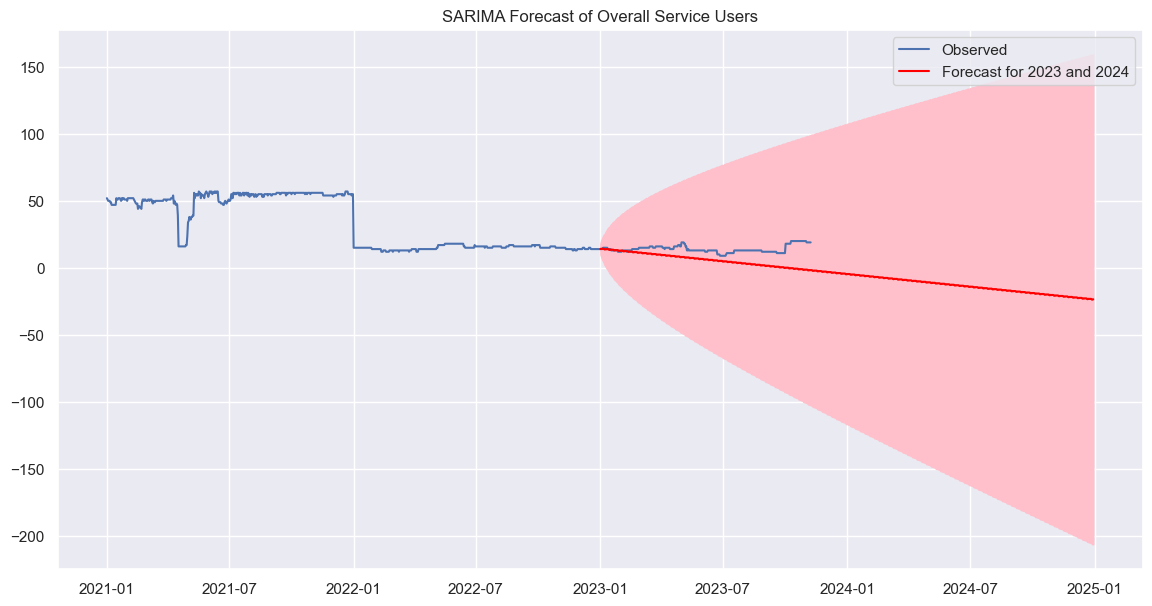

In [40]:
    # for 1 area: 
FSA = 'M5S'

by_fsa = userc_by_fsa[userc_by_fsa["FSA_code"] == FSA] 
# by_fsa = by_fsa["OCCUPANCY_DATE, SERVICE_USER_COUNT"]
# Define a SARIMA model for the aggregated time series data
# The order parameter specifies the AR, differencing, and MA terms, respectively.
# The seasonal_order parameter adds seasonal terms with a weekly periodicity (specified as 7).
model_overall_users = SARIMAX(by_fsa["SERVICE_USER_COUNT"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality assumed

# Fit the SARIMA model to the data.
# The disp=False argument suppresses convergence output for cleaner presentation.
sarima_overall_users_result = model_overall_users.fit(disp=False)

# Forecast the service users for the next 730 days (covering 2023 and 2024).
forecast_overall_users = sarima_overall_users_result.get_forecast(steps=730)

# Extract the mean forecast values from the forecast results.
mean_forecast_overall_users = forecast_overall_users.predicted_mean

# Extract the confidence intervals for the forecast. 
# This provides an upper and lower bound for the forecast, indicating the uncertainty.
confidence_intervals_overall_users = forecast_overall_users.conf_int()

# Set up the figure and axis for plotting with a specified size.
plt.figure(figsize=(14, 7))

# Plot the observed data in blue.
all_by_fsa = toronto_shelter_usage_all["SERVICE_USER_COUNT"][toronto_shelter_usage_all["FSA_code"] == FSA]
# print(all_by_fsa.index)
# print(all_by_fsa.head())
plt.plot(all_by_fsa.index, all_by_fsa, label='Observed')
# print(toronto_shelter_usage_all.index)
# print(toronto_shelter_usage_all["SERVICE_USER_COUNT"])

# Plot the forecasted data in red.
plt.plot(mean_forecast_overall_users.index, mean_forecast_overall_users, color='red', label='Forecast for 2023 and 2024')

# Fill the area between the upper and lower confidence intervals with pink to indicate uncertainty.
plt.fill_between(confidence_intervals_overall_users.index, 
                 confidence_intervals_overall_users.iloc[:, 0], 
                 confidence_intervals_overall_users.iloc[:, 1], color='pink')

# Add a legend to the plot for clarity.
plt.legend()

# Add a title to the plot.
plt.title('SARIMA Forecast of Overall Service Users')

# Display the plot.
plt.show()

In [ ]:
# to do 